In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gpflow

from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter

import ipywidgets as widgets
from IPython.display import display

%matplotlib nbagg

from typing import List, Optional, Union
from gpflow.base import Parameter
from gpflow.utilities.ops import difference_matrix
from gpflow.kernels.base import Kernel
from gpflow.kernels.stationaries import IsotropicStationary, Stationary

In [950]:
pd.read_csv("birthdates-1968-1988.csv")

,year,month,day,births,day_of_year,day_of_week
0,1969,1,1,8486,1,3
1,1969,1,2,9002,2,4
2,1969,1,3,9542,3,5
3,1969,1,4,8960,4,6
4,1969,1,5,8390,5,7
...,...,...,...,...,...,...
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5


In [2]:
data = pd.read_csv("birthdates-1968-1988.csv")

day_of_week = np.array(data.day_of_week, dtype="float64").reshape(7305, 1)
day_of_year = np.array(data.day_of_year, dtype="float64").reshape(7305, 1)
k = 7
l = 1
for i in range(7500):
    day_of_week = np.append(day_of_week, k)
    day_of_year = np.append(day_of_year, l)
    k += 1
    l += 1
    if k == 8:
        k = 1
    if l == 366:
        l = 1
    
weekends = 1 * np.add(day_of_week == 6, day_of_week == 7) 

weekdays = np.add(day_of_week == 1, day_of_week == 2) 
weekdays = np.add(weekdays, day_of_week == 3)
weekdays = np.add(weekdays, day_of_week == 4)
weekdays = 1 * np.add(weekdays, day_of_week == 5)


Xlist = [i for i in range(1, 7306, 1)]
X = np.array(Xlist, dtype="float64").reshape(7305, 1)

Y = data["births"]
ybar = np.mean(Y)
s = np.std(Y)

Y = np.array((Y - ybar) / s).reshape(7305, 1)

data = (X, Y)
N = len(X)

M = 100
idx = [int(i) for i in list(np.linspace(0, N, M, endpoint=False))]
Z = X[idx, :].copy()

minibatch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

In [3]:
days = np.add(day_of_year == 1, day_of_year == 60)
days = np.add(days, day_of_year == 186)
days = np.add(days, day_of_year == 153)
days = np.add(days, day_of_year == 260)
days = np.add(days, day_of_year == 327)
days = np.add(days, day_of_year == 332)
days = 1 * np.add(days, day_of_year == 360)

In [4]:
class WDaysPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
    
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)

    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        Ix = tf.gather_nd(tf.constant(weekdays), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekdays), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K   

class WEndsPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(weekends), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekends), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

class DayOfYearPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(days), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(days), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

## Modelo

In [5]:
k1 = gpflow.kernels.SquaredExponential(0.2, 260)  # long trend
k2 = gpflow.kernels.SquaredExponential(0.01, 30)  # short trend
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(2, 0.8), 7) * gpflow.kernels.SquaredExponential(0.5, 2000)
k4 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(0.2, 0.2), 365.25) * gpflow.kernels.SquaredExponential(1, 1000)
k5 = WDaysPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)  # weekday
k6 = WEndsPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)
k7 = DayOfYearPeriodic(gpflow.kernels.SquaredExponential(1, 5000), 365.25)
k8 = gpflow.kernels.SquaredExponential(1, 1200) # 0.005
k9 = gpflow.kernels.White(0.01)

kernel = k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, whiten=True, num_data=N)

gpflow.set_trainable(m.kernel.kernels[2].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[3].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[4].period, False)
gpflow.set_trainable(m.kernel.kernels[5].period, False)
gpflow.set_trainable(m.kernel.kernels[6].period, False)
gpflow.set_trainable(m.inducing_variable, True)

<IPython.core.display.Javascript object>


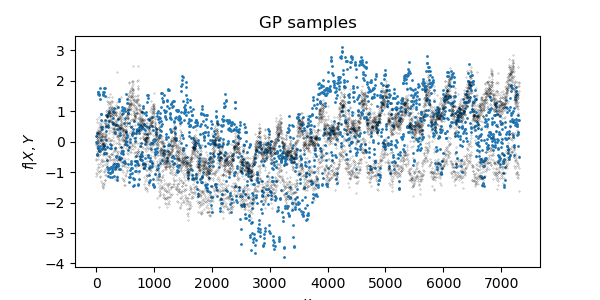

In [6]:
# Genera muestras a priori para testear el kernel

Xt = np.round_(np.linspace(0, 7305, 2000)).astype(np.float64)[:, None]
num_samples = ci_niter(1)
f = m.predict_f_samples(Xt, num_samples)

plt.figure(figsize=(6,3))
for i in range(0, num_samples):
    plt.plot(Xt, f[i, :, :], ".", alpha=1, markersize=2)

plt.plot(X, Y, "k.", alpha=0.5, markersize=0.5)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("GP samples")

plt.show()

In [7]:
def run_adam(model, iterations):
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)  
    optimizer = tf.optimizers.Adam()
    
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            print(step, elbo)
            logf.append(elbo)
    print(step, -training_loss().numpy())
    return logf

In [8]:
maxiter = ci_niter(40000)
logf = run_adam(m, maxiter)

0 -29669.775689479844
10 -26861.088473425356
20 -24586.835815055856
30 -24028.75922696734
40 -22195.39124402661
50 -21456.53319116918
60 -21602.41925732432
70 -19747.541929575702
80 -20210.272733242102
90 -19168.3014436424
100 -19016.840724170044
110 -19140.82120873066
120 -18377.544681594536
130 -18192.225241507887
140 -18443.732364663087
150 -17827.201869251803
160 -18351.322335727935
170 -17364.68747637659
180 -17321.1437760132
190 -17398.33608486627
200 -16716.179720330078
210 -17216.501386260436
220 -16933.593000757995
230 -16429.98779374123
240 -16458.697914270022
250 -15988.030969685175
260 -16169.847589043231
270 -16036.447302447663
280 -15776.25512803726
290 -15914.555534066474
300 -15409.659695287914
310 -15226.711215800175
320 -15303.974712186538
330 -15065.677973385255
340 -15564.014428729557
350 -15040.925290843521
360 -14958.258412664069
370 -14866.453180165581
380 -14655.348510022422
390 -14787.243793052248
400 -14685.145715628232
410 -14458.022438840488
420 -14946.68975

3430 -6978.535321996587
3440 -7277.190664821883
3450 -6903.908037242885
3460 -6760.86310396863
3470 -6947.494871062081
3480 -7062.416879524733
3490 -6667.60613086587
3500 -6707.92994978259
3510 -7016.464771076813
3520 -7217.824777468825
3530 -6761.435866117097
3540 -6809.825495589505
3550 -7020.937907119424
3560 -7083.125550049269
3570 -6625.241590349378
3580 -6705.966209361009
3590 -6600.769301970828
3600 -6827.676538582217
3610 -6607.284565358203
3620 -6974.280602819569
3630 -6879.433366050236
3640 -6707.678819496164
3650 -6570.317991757444
3660 -6713.58167853406
3670 -6585.548497715836
3680 -6541.6339876051625
3690 -6421.547852547615
3700 -6589.496466448209
3710 -6430.921656995294
3720 -6535.97979336582
3730 -6256.659887480834
3740 -6361.019164467869
3750 -6342.4963879446805
3760 -6196.4691410025325
3770 -6211.794363710724
3780 -6285.625966375602
3790 -6376.003935891052
3800 -6436.286337995027
3810 -6187.578195662556
3820 -6034.238361564871
3830 -6053.118660226914
3840 -6396.6454966

6820 -2315.6086527202506
6830 -2935.396906860347
6840 -2452.3139938501363
6850 -2647.7661542772958
6860 -2720.7722279782647
6870 -3183.3704136250467
6880 -2675.5127358578293
6890 -2318.5254773815795
6900 -2860.405847115839
6910 -4233.4635205869745
6920 -2088.9766341313975
6930 -3990.2413495644796
6940 -3975.4291839220464
6950 -3928.8194603275156
6960 -1532.350714119793
6970 -3095.173009272844
6980 -2698.291509023302
6990 -2609.7460218249307
7000 -2921.5722002362254
7010 -3439.307785065621
7020 -3861.3125977271807
7030 -2355.9576685673983
7040 -1828.8501544867224
7050 -2500.6959372231836
7060 -3874.8564675593775
7070 -1686.7945876528759
7080 -3448.299683283745
7090 -2365.653801249621
7100 -3356.980762749941
7110 -1829.609325857287
7120 -2649.184057090245
7130 -2066.272568593343
7140 -2643.0415342950273
7150 -2859.75224143311
7160 -2529.235404250375
7170 -3005.6463528448244
7180 -1677.331278204404
7190 -3476.7507881995907
7200 -1760.9465766648163
7210 -2421.533902071606
7220 -3933.314352

10180 -1800.9972663155972
10190 -1765.5531987906434
10200 -2057.3457759232165
10210 -2335.328076495683
10220 -2150.5174011654135
10230 -2372.38378504283
10240 -1998.5251504051282
10250 -2787.8023187583653
10260 -3125.7802089156394
10270 -581.8969248632227
10280 -2378.0455035220166
10290 -2774.4115574522316
10300 -2549.488364628232
10310 -3052.8411332404976
10320 -2342.8295257673744
10330 -1582.2388082862135
10340 -1497.4165294662782
10350 -1620.261711984205
10360 -3710.2320391244602
10370 -1301.4586389942153
10380 -1846.9122010177837
10390 -1256.913491013716
10400 -3264.9675722077045
10410 -2112.955394028278
10420 -1812.5613673084847
10430 -2018.889949318063
10440 -1329.0055944967996
10450 -2740.393206672633
10460 -2481.6271362851194
10470 -2807.041464247319
10480 -1674.6182963855774
10490 -1170.6669731122558
10500 -2286.7099930944046
10510 -3752.784861815112
10520 -1452.6905956232274
10530 -4408.256953623358
10540 -1940.062583008809
10550 -2199.358201973995
10560 -2704.4325292807284
1

13400 -3997.507235415951
13410 -3371.2502506493593
13420 -3229.437391844607
13430 -1578.8936743333875
13440 -2183.3389252283273
13450 -1339.8272207280127
13460 -3169.8380407362547
13470 -2800.7375337518497
13480 -3162.681283743976
13490 -3709.3187957027735
13500 -1566.2901523053908
13510 -2593.417126420463
13520 -1987.7044045249586
13530 -1575.2612877526658
13540 -3081.690322770609
13550 -2078.1649847729245
13560 -2219.936643595983
13570 -3807.7282780394917
13580 -649.017840955569
13590 -3597.3991393331416
13600 -2292.8347776225914
13610 -1284.597158266887
13620 -454.4001624224121
13630 -2153.9446633536445
13640 -1731.5919152659103
13650 -3844.9648178269445
13660 -2364.3100148918975
13670 -3371.519859296943
13680 -832.4645868007276
13690 -1514.218195179197
13700 -1986.9006797479628
13710 -2265.0701347562667
13720 -1770.3750649870183
13730 -1428.441133308372
13740 -1230.4368529007477
13750 -2154.3880588994384
13760 -1874.4188450231336
13770 -1876.9777261858308
13780 -2328.4452794699755


16620 -2130.11775315555
16630 -2937.412785439866
16640 -2320.841580662815
16650 -1956.1032352934192
16660 -2377.3177988351517
16670 -3631.1779503163402
16680 -1804.4547950141905
16690 -2084.7898647379666
16700 -1771.496857617511
16710 -1885.5637482675224
16720 -1837.2134743497886
16730 -2357.3160320351562
16740 -3060.640090503094
16750 -1408.9269021820564
16760 -2784.0941986824087
16770 -2223.3609661425817
16780 -2320.6610946612154
16790 -1081.8744779856163
16800 -1050.1732446331814
16810 -2547.8580101155344
16820 -1556.418300828431
16830 -2629.1725789489706
16840 -3376.6724829200716
16850 -1643.255394624078
16860 -1581.444606741601
16870 -2821.612939950038
16880 -845.4369465494486
16890 -2189.217341310068
16900 -2883.079411733536
16910 -2650.7013681085095
16920 -900.8512348973316
16930 -878.3097243087515
16940 -2400.3245073428116
16950 -2932.6641491730124
16960 -2153.9579970126983
16970 -3040.7592195935304
16980 -1753.1582483723257
16990 -1635.3839812244325
17000 -1704.892464829453
17

19830 -976.7150782362338
19840 -1933.981688905694
19850 -3852.1049433892886
19860 -1017.5708667799888
19870 -2070.7444771418386
19880 -1546.4713613965869
19890 -2837.9306102165374
19900 -3459.7779341710907
19910 -3427.6293429967213
19920 -1781.7299548065332
19930 -1717.1919946499422
19940 -1880.9769024282687
19950 -2068.5137062223002
19960 -2124.216394443249
19970 -1140.089727764655
19980 -1406.1392173999511
19990 -2573.252232546032
20000 -1152.9105816810666
20010 -2948.5259126539813
20020 -400.48251075628747
20030 -2536.0168847713708
20040 -2092.333133208211
20050 -2988.848468772823
20060 -2118.283555668522
20070 -1349.605030121615
20080 -2476.899375465114
20090 -2259.75182008729
20100 -3217.5050924152974
20110 -1650.8064944565745
20120 -1406.3897409557626
20130 -4902.657651376631
20140 -2324.8487573945763
20150 -982.0963470265986
20160 -2451.8459643330298
20170 -1549.566144720685
20180 -3300.0959462568107
20190 -2012.7163280323962
20200 -2282.7537536552236
20210 -2189.5493274511223
2

23050 -1147.1788461657181
23060 -1026.441902182162
23070 -2063.3141613428984
23080 -1318.492375670888
23090 -2051.194735364559
23100 -1364.0046358148852
23110 -1329.2670060178352
23120 -3707.3483999645714
23130 -1629.475613338249
23140 -924.8187464872808
23150 -1723.697007669795
23160 -1895.8090055383502
23170 -2064.876913490391
23180 -2308.2946185508886
23190 -2241.5341163929606
23200 -517.9592433352353
23210 -771.9086772874812
23220 -1231.2208918591198
23230 -2551.3789400960786
23240 -1240.4586687986623
23250 -2377.280868336921
23260 -1727.0965058665463
23270 -2153.7011244063974
23280 -1920.2741093643226
23290 -2378.979567402394
23300 -1447.5174718931999
23310 -551.74171249391
23320 -2831.9584928023814
23330 -2315.516949714024
23340 -1111.6021561246164
23350 -2793.8878643971057
23360 -3752.510758519972
23370 -1482.8047331298962
23380 -2440.8412454637946
23390 -658.84677047349
23400 -1676.212389252549
23410 -3601.275068348533
23420 -1322.4289138893341
23430 -543.7527479651179
23440 -1

26280 -2302.1854126462754
26290 -1015.9373124437516
26300 -3363.9685882640256
26310 -1251.8253955900175
26320 -1458.1320703447861
26330 -2549.485068652988
26340 -1575.3610674151905
26350 -1861.4143116757896
26360 -1992.5369965942832
26370 -612.165659104241
26380 -2546.3535777111765
26390 -2572.4612719718107
26400 -1752.1525432019093
26410 -2099.484132076224
26420 -2027.0376361611313
26430 -2655.4765971577244
26440 -1480.5536481144047
26450 -2401.7896054289554
26460 -5236.881830051989
26470 -2253.941647965197
26480 -2079.2605401074698
26490 -3339.112957729926
26500 -1922.6098029836712
26510 -3043.607388980733
26520 -2978.7234212458184
26530 -894.8180306378787
26540 -2485.936262658276
26550 -1060.0934493168313
26560 -2525.3244330349867
26570 -1911.5332160583298
26580 -1767.685879054306
26590 -1879.710284644767
26600 -2975.5202857069935
26610 -2021.1268139246217
26620 -1727.7934009156693
26630 -2906.415604417742
26640 -735.7429253765018
26650 -1725.1941362019986
26660 -3526.967230812411
2

29500 -3435.562285594615
29510 -2092.654396972696
29520 -1846.3921375910545
29530 -3440.0177436725726
29540 -823.5655195816404
29550 -2841.5882386610715
29560 -3347.7812726406437
29570 -2211.227266067233
29580 -2596.5129649876753
29590 -1435.5483730214341
29600 -1519.7351275808055
29610 -721.4654404287751
29620 -2314.45500596594
29630 -2130.435648982156
29640 -1294.280824268237
29650 -1719.7593030071298
29660 -2167.1124837502534
29670 -2329.4869470476897
29680 -1503.7477404514884
29690 -3300.8066659984324
29700 -1778.051049328478
29710 -1083.7008977298417
29720 -1642.9229963626915
29730 -2048.3076370625868
29740 -953.4062319814254
29750 -1243.1512676340417
29760 -2410.888564373143
29770 -756.5105696256167
29780 -1904.3236221899422
29790 -2844.313124306929
29800 -631.3490678446838
29810 -2077.965254556348
29820 -2273.739484532276
29830 -2751.1417885894416
29840 -1669.793197721497
29850 -2306.676532051052
29860 -2366.370111241076
29870 -733.0995342975473
29880 -2429.4969639001756
29890 -

32720 -1189.7006039793102
32730 -1590.1601149651526
32740 -2529.2244927823167
32750 -1790.441699004685
32760 -3900.0653720984096
32770 -1191.5523194827963
32780 -1526.8576619580103
32790 -3296.6240158470264
32800 -2497.7427667311536
32810 -1166.1216675908788
32820 -1472.231189874957
32830 -2330.7170643656764
32840 -2349.074738032797
32850 -2080.284237256521
32860 -1164.3527880286356
32870 -2846.9192868920104
32880 -2391.9756437658893
32890 -1587.3208792166324
32900 -1103.7149210287598
32910 -973.1684399363769
32920 -3277.1991518154023
32930 -2303.009044327731
32940 -2239.983856765887
32950 -2837.1590779975063
32960 -1475.5862614532516
32970 -1966.8837295929034
32980 -2903.8875495970574
32990 -1716.8461176847156
33000 -1028.4800765376758
33010 -2295.1000518002656
33020 -1256.5504895814258
33030 -2169.3387107125563
33040 -2968.375965145056
33050 -2499.2257535733406
33060 -1840.3326546533326
33070 -2607.115428249266
33080 -1770.42449225249
33090 -1540.8189861688356
33100 -2068.70753242206

35950 -1055.7048378524435
35960 -891.0890877384772
35970 -1077.3904029599812
35980 -1690.7149970551643
35990 -895.4733528720546
36000 -2410.852595231255
36010 -2331.080543621365
36020 -2251.8228321192328
36030 -1813.9631155257614
36040 -1645.2878155184612
36050 -1963.1215184824
36060 -2148.5226141917474
36070 -2705.0039950584915
36080 -2971.1089281856644
36090 -1658.9626855930305
36100 -1058.6171058757275
36110 -3481.0112139854177
36120 -2403.3596229274553
36130 -1706.698865310033
36140 -2116.4337870458535
36150 -2032.7616574702013
36160 -2718.3928955568035
36170 -2538.628332513611
36180 -2277.9275403930046
36190 -1423.8413822504544
36200 -1424.5547283318867
36210 -1040.3499509166827
36220 -1986.9562694914478
36230 -1869.7638022905182
36240 -1319.0659000584094
36250 -999.1171274806215
36260 -2445.4784727668084
36270 -3002.61000212008
36280 -1908.2439651212978
36290 -2583.5931610609628
36300 -1221.0801150938696
36310 -1967.9903076141716
36320 -3009.4630490214186
36330 -983.2988462881634

39160 -819.6286538284978
39170 -2314.679733058606
39180 -1830.6118635552468
39190 -762.9762510239135
39200 -3484.621688514844
39210 -999.3992507246571
39220 -3051.9797477744214
39230 -2326.302097174965
39240 -3463.584184729069
39250 -2800.4479896049143
39260 -2191.8240668314097
39270 -1756.5022656106773
39280 -2450.647043964012
39290 -1056.1576996825736
39300 -1302.0071703663898
39310 -1943.1107777040206
39320 -4630.491391378354
39330 -414.1595242050871
39340 -3381.955456674261
39350 -2154.9763529275956
39360 -2147.732663847414
39370 -1352.8595006125952
39380 -2060.1619263718444
39390 -1268.3374824732932
39400 -3084.574688288304
39410 -2363.887402088046
39420 -2780.3744930257913
39430 -2131.2831355710387
39440 -1917.6976583262674
39450 -1341.9803386676867
39460 -2970.8577973420347
39470 -2139.3872145301557
39480 -2689.619262308384
39490 -908.3973123658495
39500 -932.9435889909901
39510 -1087.563677572936
39520 -4078.3610096073817
39530 -2060.986286292191
39540 -2676.6594808347927
39550

<IPython.core.display.Javascript object>


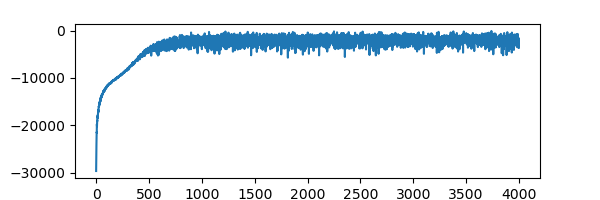

In [9]:
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(logf)
plt.show()

In [10]:
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.05806394145046908
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,264.2620919390927
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.972112484461729e-09
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,42.35621829697248
SVGP.kernel.kernels[2].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.8936349867560325
SVGP.kernel.kernels[2].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6499656710786288
SVGP.kernel.kernels[2].kernels[0].period,Parameter,Softplus,,True,(),float64,6.999909113714987
SVGP.kernel.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.45221434971210206
SVGP.kernel.kernels[2].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2009.3348047599113
SVGP.kernel.kernels[3].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.3371420606135664


In [11]:
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime
dates.set_epoch("1969-01-01T00:00")

In [12]:
data = pd.read_csv("birthdates-1968-1988.csv")
Xd = num2date(data.index.values)

## Figuras

In [15]:
f = m.predict_f_samples(Xt, full_cov=True, num_samples=10)

<IPython.core.display.Javascript object>


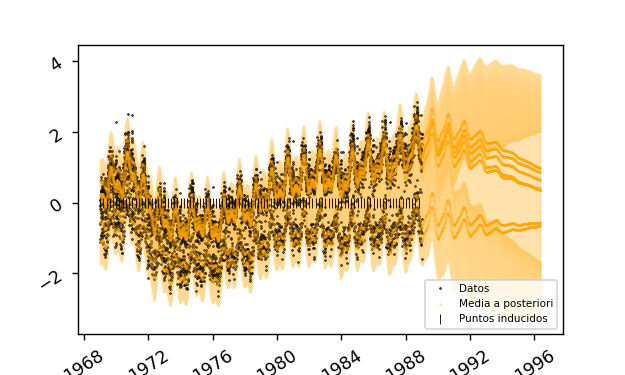

interactive(children=(FloatSlider(value=1.0, description='data alpha:', max=1.0), FloatSlider(value=4.0, descr…

In [44]:
n = 10001
Xt = np.round_(np.linspace(0, 10000, n)).astype(np.float64)[:, None]
mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

fig, ax = plt.subplots(1, figsize=(5, 3))
plt.title('Predicciones después de entrenar el modelo', fontsize=8)

def update_plot(da, ds, ms, ma, fa, fw):
    np.random.seed(0)
    ax.cla()
    ax.tick_params(labelrotation=33)
    ax.plot_date(Xd, Y, '.', label='Datos', alpha=da, markersize=ds, color='k')
    (mean,) = ax.plot(Xt[:-1], mpostc, '.', color='orange', markersize=ms, alpha=ma, label='Media a posteriori')
    col = mean.get_color()
    ax.plot(Xt[:-1, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col)
    ax.plot(Xt[:-1, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col) 
    
    ax.fill_between(Xt[:-1, 0],
                    (mpostc - 2 * spostc ** 0.5)[:, 0],
                    (mpostc + 2 * spostc ** 0.5)[:, 0],
                    color = col,
                    alpha = fa, 
                    lw = fw)
    
    
#     for i in range(0, 30):  #'num_samples'
#         ax.plot(Xt[:-1] , f[i, 1:, :], 'b-', alpha=0.15, lw=1.5)
        
    ax.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
    ax.legend(loc='lower right', fontsize=6)
    



da = widgets.FloatSlider(min=0, max=1, value=1, description='data alpha:')
ds = widgets.FloatSlider(min=0, max=4, value=4, description='data size:')
ms = widgets.FloatSlider(min=0, max=4, value=4, description='mean size:')
ma = widgets.FloatSlider(min=0, max=1, value=1, description='mean alpha:')
fw = widgets.FloatSlider(min=0, max=4, value=0.5, description='fill size:')
fa = widgets.FloatSlider(min=0, max=1, value=0.33, description='fill alpha:')


widgets.interactive(update_plot, 
                    da=da, 
                    ds=ds,
                    ms=ms, 
                    ma=ma, 
                    fa=fa, 
                    fw=fw)

In [230]:
import matplotlib.colors as mcolors
from matplotlib.gridspec import  GridSpec
grid = GridSpec(3, 1, 
                left=0.1, bottom=0.15, 
                right=0.94, top=0.94, wspace=0.3, hspace=0.3)

<IPython.core.display.Javascript object>


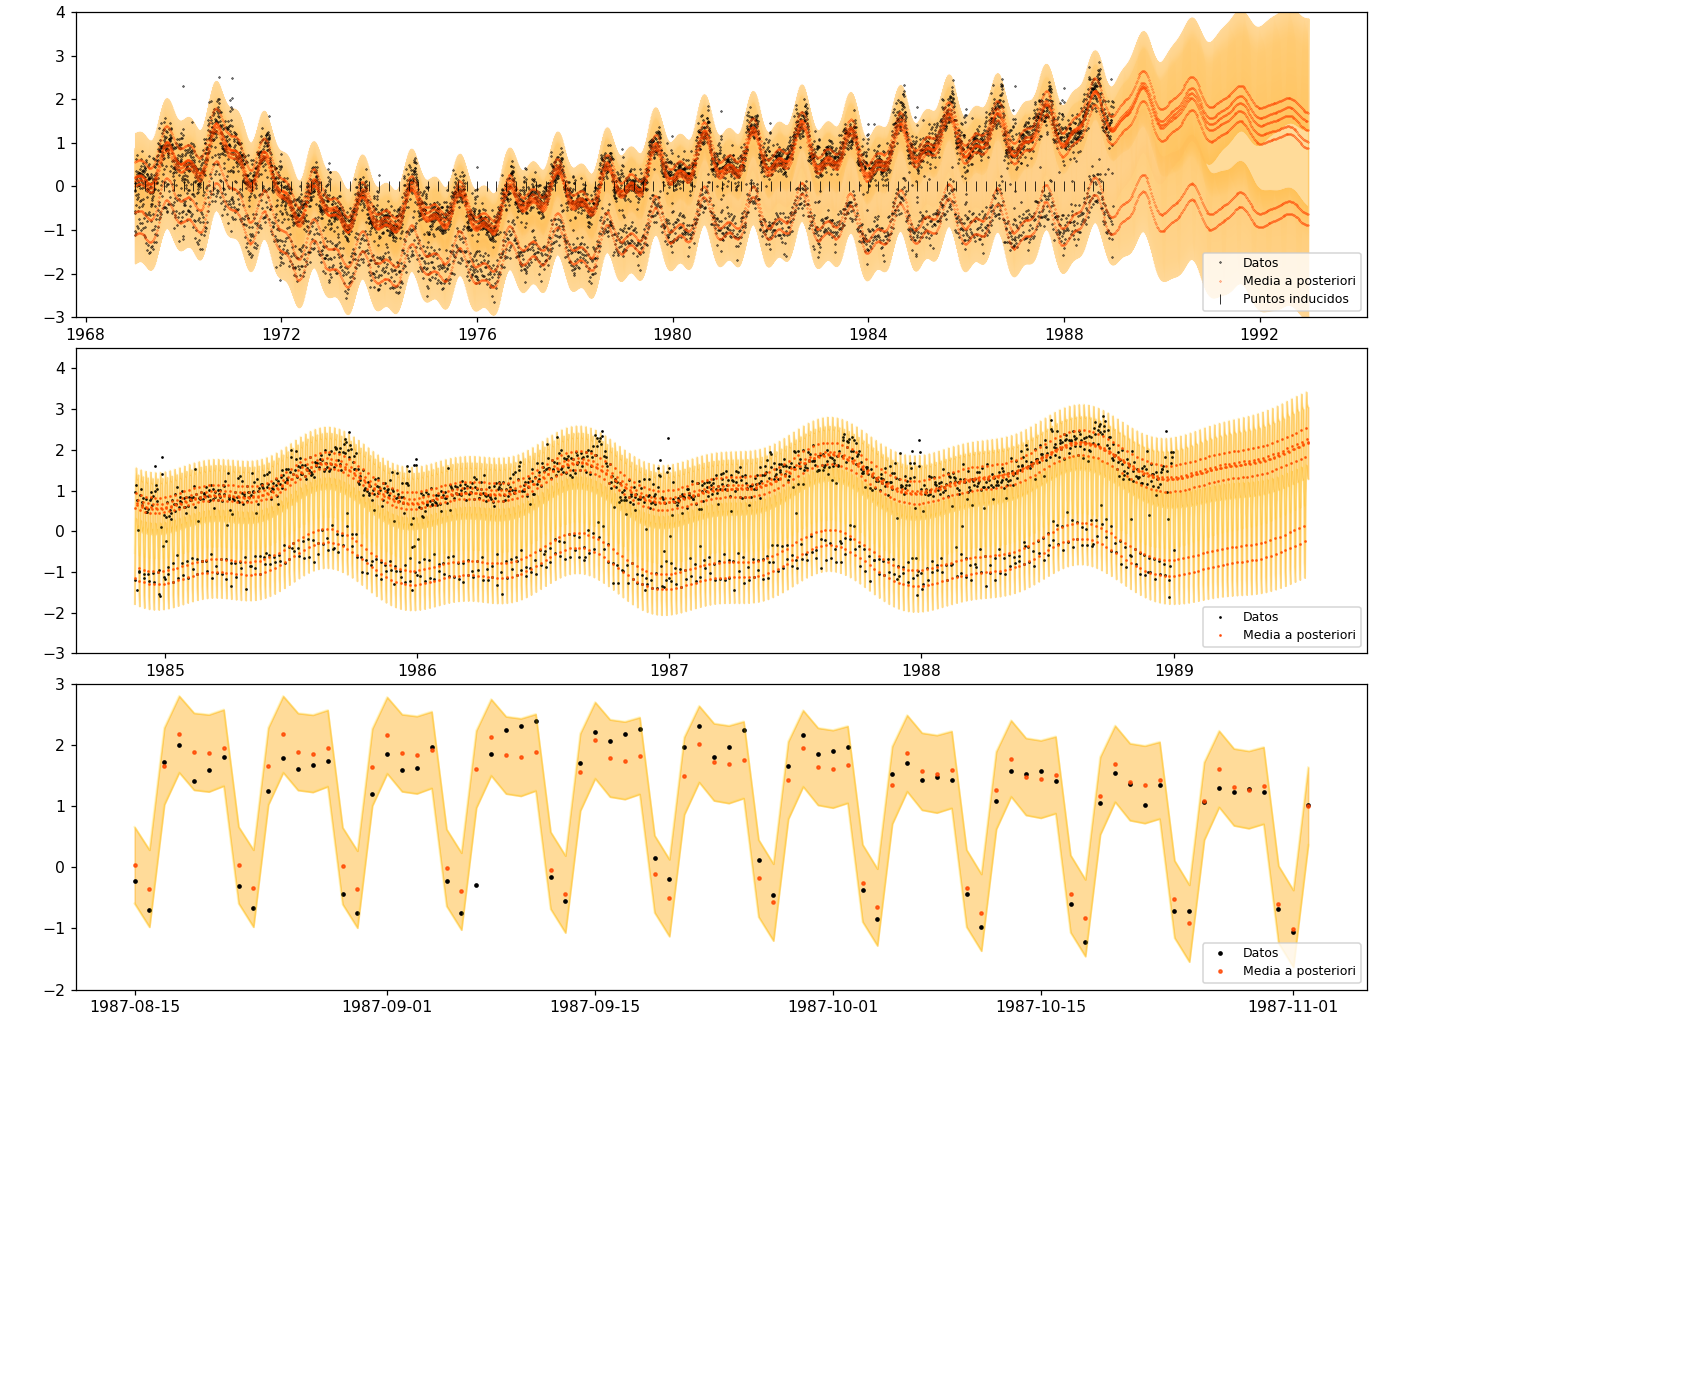

In [268]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(3, 1, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 11))
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, '.', label='Datos', alpha=1, markersize=0.8, color='k')
(mean,) = ax1.plot(Xt, mpostc, '.', color='orangered', markersize=0.7, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
# ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(-3,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=1.5, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=1.5, alpha=0.9, label='Media a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax2.set_yticks([])
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(-3,4.5)

k, t = 80,6800
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=4, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=4, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax3.set_yticks([])
ax3.legend(loc='lower right', fontsize=8)
ax3.set_ylim(-2,3)

fig.savefig('model.png', dpi=200) 

<IPython.core.display.Javascript object>


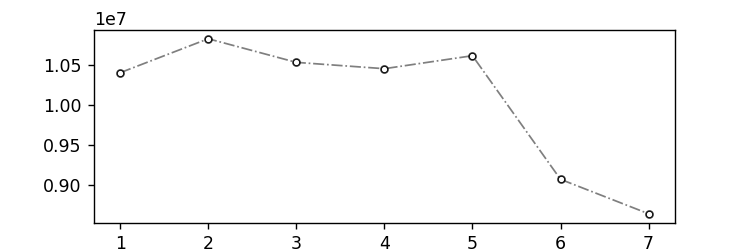

In [23]:
# ver días del modelo
# f = m.predict_f_samples(Xt, num_samples)
sample1 = f[0,:,:] * s + ybar
x = {'day_of_week': [], 'births':[]}
ds = 3
mes = 1
y = 1969
for i in range(7305):
    x['day_of_week'].append(ds)
    x['births'].append(sample1[i])
    ds += 1
    if ds == 8:
        ds = 1
df = pd.DataFrame(x)

x = []
y = []


for i in range(2, 8):
    x.append(i - 1)
    y.append(np.sum(df[df.day_of_week == i].births))
x.append(7)
y.append(np.sum(df[df.day_of_week == 1].births))

fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(x, y, 'k-.', alpha=0.5, lw=1)
ax.plot(x, y, 'ko', markersize=4, alpha=0.8)
ax.plot(x, y, 'wo', markersize=2, alpha=1)

<IPython.core.display.Javascript object>


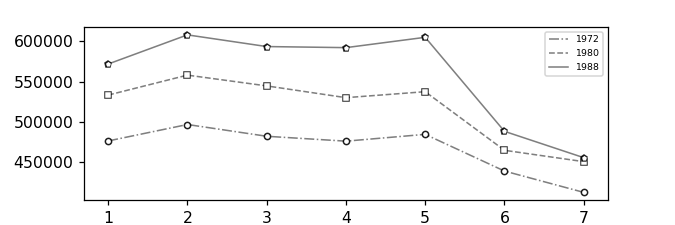

In [568]:
# ver días

x = []
y1 = []
y2 = []
y3 = []

A1 = data[data.year == 1972]
A2 = data[data.year == 1980]
A3 = data[data.year == 1988]

for i in range(1, 8):
    x.append(i)
    
    y1.append(np.sum(A1[A1.day_of_week == i].births))
    y2.append(np.sum(A2[A2.day_of_week == i].births))
    y3.append(np.sum(A3[A3.day_of_week == i].births))
    
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(x, y1, 'k-.', alpha=0.5, lw=1, label='1972')
ax.plot(x, y1, 'ko', markersize=4, alpha=0.8)
ax.plot(x, y1, 'wo', markersize=2, alpha=1)

ax.plot(x, y2, 'k--', alpha=0.5, lw=1, label='1980')
ax.plot(x, y2, 'ks', markersize=4, alpha=0.8)
ax.plot(x, y2, 'ws', markersize=2, alpha=1)

ax.plot(x, y3, 'k-', alpha=0.5, lw=1, label='1988')
ax.plot(x, y3, 'kp', markersize=4, alpha=0.8)
ax.plot(x, y3, 'wp', markersize=2, alpha=1)


# ax.axhline(y=np.mean(y), color='k', lw=1)
ax.legend(loc='upper right', fontsize=6)